In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const
import astropy.constants as aconst
from pycbc.filter import sigmasq
from pycbc import waveform
from calcwf import chirp2total, gen_wf, ceiltwo, gen_psd, shifted_e, shifted_e_approx
from scipy.interpolate import interp1d
from scipy.optimize import minimize
import os
import time
import pickle

# Exact effective chirp mass

To work out more exact effective chirp mass, we need to follow original approach in Favata et al. (https://arxiv.org/pdf/2108.05861.pdf), but retain $e_t$ instead of approximating it to lowest order. The effective chirp mass will then appear in the second derivative of the phae, which we must calculate.

$$
\Psi_\textrm{ecc, 0PN} \propto \frac{1}{\mathcal{M}^{5/3}f^{5/3}}\left[1-\frac{2355}{1462}e_t^2\right]
$$

$$
\frac{d\Psi}{df} \propto - \frac{5}{3\mathcal{M}^{5/3}f^{8/3}}\left[1-\frac{2355}{1462}e_t^2\right] - \frac{1}{\mathcal{M}^{5/3}f^{5/3}} \left[\frac{2355}{1462}\frac{de_t^2}{df}\right]
$$

$$
\frac{d^2\Psi}{df^2} \propto \frac{40}{9\mathcal{M}^{5/3}f^{11/3}}\left[1-\frac{2355}{1462}e_t^2\right] + \frac{10}{3\mathcal{M}^{5/3}f^{8/3}}\left[\frac{2355}{1462}\frac{de_t^2}{df}\right] - \frac{1}{\mathcal{M}^{5/3}f^{5/3}} \left[\frac{2355}{1462}\frac{d^2e_t^2}{df^2}\right]
$$
$$
\frac{d^2\Psi}{df^2} \propto \frac{1}{\mathcal{M}^{5/3}f^{5/3}} \left[1-\frac{2355}{1462}e_t^2 + \frac{7065}{5848}f\frac{de_t^2}{df} - \frac{4239}{11696}f^2\frac{d^2e_t^2}{df^2}\right]
$$

$$
\mathcal{M}_\textrm{ecc} = \mathcal{M} \left(1-\frac{2355}{1462}e_0^2 + \frac{7065}{5848}f_0\left.\frac{de_t^2}{df}\right|_{f=f_0} - \frac{4239}{11696}f_0^2\left.\frac{d^2e_t^2}{df^2}\right|_{f=f_0}\right)^{-3/5}
$$

The effective chirp mass therefore depends on derivatives of $e_t$, which we will need to calculate numerically. Using the leading order expression for $e_t$, this recovers the equation in Favata et al. (both analytically and numerically with the function below).

In [2]:
# Differentiates square of shifted e eqn using np.gradient()
def diff_shifted_e2(f_0, e_0, n=5, df=0.1, order=2):

    # Ensure e_0 is array
    e_0s = np.array(e_0).flatten()

    # Setup differentiation
    assert n%2 == 1
    f_arr = np.linspace(f_0 - int(n/2)*df, f_0 + int(n/2)*df, n)
    diff_arrs = np.empty((order+1, len(e_0s), n))

    # Calculate for each eccentricity
    for i, e_0 in enumerate(e_0s):
        e_arr = shifted_e(f_arr, f_0, e_0)**2
        diff_arrs[0][i] = e_arr
    
        # Perform differentiation
        for j in range(order):
            diff_arrs[j+1][i] = np.gradient(diff_arrs[j][i], df)

    # Evaluate at f_0
    return diff_arrs[1:,:,int(n/2)]

# Plots

In [3]:
def favata_et_al_freq(given_e, given_chirp, e_vals):

    # Find effective chirp mass of given point
    eff_chirp = given_chirp*(1+(157/24)*given_e**2)**(3/5)

    # Convert to chirp mass values
    chirp_vals = eff_chirp/(1+(157/24)*e_vals**2)**(3/5)

    return chirp_vals

def favata_et_al_amp(given_e, given_chirp, e_vals):

    # Find effective chirp mass of given point
    eff_chirp = given_chirp*(1-(157/48)*given_e**2)**(6/5)

    # Convert to chirp mass values
    chirp_vals = eff_chirp/(1-(157/48)*e_vals**2)**(6/5)

    return chirp_vals

def favata_et_al_phase(given_e, given_chirp, e_vals):

    # Find effective chirp mass of given point
    eff_chirp = given_chirp/(1-(157/24)*given_e**2)**(3/5)

    # Convert to chirp mass values
    chirp_vals = eff_chirp*(1-(157/24)*e_vals**2)**(3/5)

    return chirp_vals

def favata_et_al_avg(given_e, given_chirp, e_vals, f_low=10, q=2):
    """
    Converts array of eccentricity values to chirp mass along a line of constant 
    effective chirp mass, as given by equation 1.1 in Favata et al. 
    https://arxiv.org/pdf/2108.05861.pdf.

    Parameters:
        given_e: Value of eccentricity for given point on line of constant effective chirp mass.
        given_chirp: Value of chirp mass for given point on line of constant effective chirp mass.
        e_vals: Frequency values to be converted.

    Returns:
        Converted chirp mass values.
    """

    # Generate waveform at given point to use in sigmasq
    h = gen_wf(f_low, given_e, chirp2total(given_chirp, q), q, 4096, 'TEOBResumS')
    h.resize(ceiltwo(len(h)))
    
    # Generate the aLIGO ZDHP PSD
    psd = gen_psd(h, f_low)

    # Calculate both integrals using sigmasq
    h = h.real().to_frequencyseries()
    ss = sigmasq(h, psd=psd, low_frequency_cutoff=f_low+3)
    ssff = sigmasq(h*h.sample_frequencies**(-7/3), psd=psd, low_frequency_cutoff=f_low+3)
    ssf = sigmasq(h*h.sample_frequencies**(-7/6), psd=psd, low_frequency_cutoff=f_low+3)

    # Use average frequency to evolve eccentricities
    avg_f = (ssff/ss-(ssf/ss)**2)**(-3/14)
    print('Average frequency: '+str(avg_f)+' Hz')
    s_given_e = shifted_e_approx(avg_f, f_low, given_e)
    print(f'Given_e shifted from {given_e} to {s_given_e}')
    s_e_vals = shifted_e_approx(avg_f, f_low, e_vals)

    # Find effective chirp mass of given point
    eff_chirp = given_chirp/(1-(157/24)*s_given_e**2)**(3/5)

    # Convert to chirp mass values
    chirp_vals = eff_chirp*(1-(157/24)*s_e_vals**2)**(3/5)

    return chirp_vals

def favata_et_al_exact(given_e, given_chirp, e_vals, f_low=10, q=2):
    """
    Converts array of eccentricity values to chirp mass along a line of constant 
    effective chirp mass, as given by equation 1.1 in Favata et al. 
    https://arxiv.org/pdf/2108.05861.pdf.

    Parameters:
        given_e: Value of eccentricity for given point on line of constant effective chirp mass.
        given_chirp: Value of chirp mass for given point on line of constant effective chirp mass.
        e_vals: Frequency values to be converted.

    Returns:
        Converted chirp mass values.
    """

    # Generate waveform at given point to use in sigmasq
    h = gen_wf(f_low, given_e, chirp2total(given_chirp, q), q, 4096, 'TEOBResumS')
    h.resize(ceiltwo(len(h)))
    
    # Generate the aLIGO ZDHP PSD
    psd = gen_psd(h, f_low)

    # Calculate both integrals using sigmasq
    h = h.real().to_frequencyseries()
    ss = sigmasq(h, psd=psd, low_frequency_cutoff=f_low+3)
    ssff = sigmasq(h*h.sample_frequencies**(-5/3), psd=psd, low_frequency_cutoff=f_low+3)
    ssf = sigmasq(h*h.sample_frequencies**(-5/6), psd=psd, low_frequency_cutoff=f_low+3)

    # Use average frequency to evolve eccentricities
    avg_f = (ssff/ss-(ssf/ss)**2)**(-3/10)
    print('Average frequency: '+str(avg_f)+' Hz')
    s_given_e = shifted_e(avg_f, f_low, given_e)
    print(f'Given_e shifted from {given_e} to {s_given_e}')
    s_e_vals = shifted_e(avg_f, f_low, e_vals)

    # Find effective chirp mass of given point
    s_given_e2_d, s_given_e2_d2 = diff_shifted_e2(avg_f, s_given_e)
    eff_chirp = given_chirp/(1 - (2355/1462)*s_given_e**2
                             + (7065/5848)*avg_f*s_given_e2_d 
                             - (4239/11696)*avg_f**2*s_given_e2_d2)**(3/5)

    # Convert to chirp mass values
    s_e_vals2_d, s_e_vals2_d2 = diff_shifted_e2(avg_f, s_e_vals)
    chirp_vals = eff_chirp*(1 - (2355/1462)*s_e_vals**2
                            + (7065/5848)*avg_f*s_e_vals2_d 
                            - (4239/11696)*avg_f**2*s_e_vals2_d2)**(3/5)

    return chirp_vals

In [4]:
def degeneracy_line(zero_ecc_chirp, ecc, f_low=10, q=2, cubic_terms=False):
    
    # Generate waveform at non-eccentric point to use in sigmasq
    h = gen_wf(f_low, 0, chirp2total(zero_ecc_chirp, q), q, 4096, 'TEOBResumS')
    h.resize(ceiltwo(len(h)))

    # Generate the aLIGO ZDHP PSD
    psd = gen_psd(h, f_low)

    # Convert to frequency series
    h = h.real().to_frequencyseries()

    # Handle array of eccentricities as input
    array = False
    if len(np.shape(ecc)) > 0:
        array = True
    ecc = np.array(ecc).flatten()

    ssfs = np.zeros(len(ecc))
    ssffs = np.zeros(len(ecc))
    sskfs = np.zeros(len(ecc))
    sskffs = np.zeros(len(ecc))
    if cubic_terms:
        sskkffs = np.zeros(len(ecc))
    # Loop over each eccentricity
    for i, e in enumerate(ecc):
        
        # Calculate a few shifted es exactly
        sparse_s_fs = np.linspace(f_low, np.max([f_low*10,100]), 11)
        sparse_s_es = shifted_e(sparse_s_fs, f_low, e)
    
        # For low eccentricities use much faster approximate shifted e
        if sparse_s_fs[-1] < h.sample_frequencies[-1]:
            approx_s_fs = np.arange(sparse_s_fs[-1], h.sample_frequencies[-1], h.delta_f)+h.delta_f
            approx_s_es = shifted_e_approx(approx_s_fs, f_low, e)
            sparse_s_fs = np.concatenate([sparse_s_fs, approx_s_fs])
            sparse_s_es = np.concatenate([sparse_s_es, approx_s_es])
    
        # Interpolate to all frequencies
        s_e_interp = interp1d(sparse_s_fs, sparse_s_es, kind='cubic', fill_value='extrapolate')
        s_es = s_e_interp(h.sample_frequencies)
    
        # Calculate k values
        ks_sqrt = np.sqrt(2355*s_es**2/1462)
    
        # Calculate integrals
        ss = sigmasq(h, psd=psd, low_frequency_cutoff=f_low+3)
        ssf = sigmasq(h*h.sample_frequencies**(-5/6), psd=psd, low_frequency_cutoff=f_low+3)
        ssff = sigmasq(h*h.sample_frequencies**(-5/3), psd=psd, low_frequency_cutoff=f_low+3)
        sskf = -sigmasq(h*ks_sqrt*h.sample_frequencies**(-5/6), psd=psd, low_frequency_cutoff=f_low+3)
        sskff = -sigmasq(h*ks_sqrt*h.sample_frequencies**(-5/3), psd=psd, low_frequency_cutoff=f_low+3)
    
        # Normalise integrals
        ssfs[i], ssffs[i], sskfs[i], sskffs[i] = np.array([ssf, ssff, sskf, sskff])/ss

        # Integral for cubic term
        if cubic_terms:
            sskkff = sigmasq(h*ks_sqrt**2*h.sample_frequencies**(-5/3), psd=psd, low_frequency_cutoff=f_low+3)
            sskkffs[i] = sskkff/ss

    # Calculate chirp mass
    if cubic_terms:
        delta_m = - (sskffs + sskkffs - ssfs*sskfs - sskfs**2)/(ssffs + sskffs - ssfs**2 - ssfs*sskfs)
    else:
        delta_m = - (sskffs - ssfs*sskfs)/(ssffs - ssfs**2)
    chirp = zero_ecc_chirp*(1+delta_m)**(-3/5)

    # If array not passed then turn back into float
    if not array:
        chirp = chirp[0]

    return chirp    

In [30]:
degeneracy_line(24, 0.5)

21.464865981040827

In [62]:
degeneracy_line(10, np.linspace(0,0.5,11), cubic_terms=False)

array([10.0000003 ,  9.992332  ,  9.96898828,  9.92883217,  9.87013543,
        9.79052482,  9.68751956,  9.55878931,  9.40326319,  9.22246932,
        9.02288576])

In [63]:
degeneracy_line(10, np.linspace(0,0.5,11), cubic_terms=True)

array([10.0000003 ,  9.99233532,  9.9690418 ,  9.92910793,  9.87102913,
        9.79279399,  9.69252502,  9.56925102,  9.42610707,  9.28091019,
        9.2082587 ])

In [41]:
favata_et_al_avg(0, 10, np.linspace(0,0.5,11))

Average frequency: 32.50748967274387 Hz
Given_e shifted from 0 to 0.0


array([10.        ,  9.99185214,  9.96738192,  9.92650897,  9.86909758,
        9.79495407,  9.70382284,  9.59538105,  9.4692315 ,  9.32489343,
        9.16179069])

In [67]:
favata_et_al_exact(0, 10, np.linspace(0,0.5,101))

Average frequency: 41.975969799508505 Hz
Given_e shifted from 0 to 5.4419751020075483e-05


array([10.        ,  9.99995216,  9.99983162,  9.99957266,  9.99923943,
        9.99881118,  9.99828598,  9.99335668,  9.99696487,  9.99615476,
        9.99520688,  9.99421202,  9.99309971,  9.991885  ,  9.9905667 ,
        9.98914348,  9.98761393,  9.98597653,  9.85476947,  9.98229861,
        9.98032348,  9.97823328,  9.97602591,  9.97369917, 10.14714344,
        9.96877491,  9.9660795 ,  9.96325457,  9.96029724,  9.95720448,
        9.95397311,  9.95059982,  9.94708112,  9.94341336,  9.76083511,
        9.92458439,  9.93096778,  9.9266191 ,  9.9222556 ,  9.91757425,
        9.92620679,  9.90820751,  9.90300335,  9.89760373,  9.89200286,
        9.8861947 ,  9.88017298,  9.87393116,  9.86746246,  9.8607598 ,
        9.85381584,  9.84662293,  9.83917315,  9.83145824,  9.82346963,
        9.81519842,  9.80663536,  9.79777086,  9.78859495,  9.77909729,
        9.76926713,  9.75909335,  9.7485644 ,  9.73766829,  9.72639259,
        9.71472445,  9.70265051,  9.69015694,  9.67722942,  9.66

/home/ben.patterson/.conda/envs/teobresums_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:435: RuntimeWarning: divide by zero encountered in power
  return self._data ** other
/home/ben.patterson/.conda/envs/teobresums_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:348: RuntimeWarning: invalid value encountered in multiply
  return self._data * other


Average frequency: 32.516248909453864 Hz
Given_e shifted from 0.05 to 0.014401891692386785
Average frequency: 41.98240505088887 Hz
Given_e shifted from 0.05 to 0.011045142897840234
Average frequency: 32.516248909453864 Hz
Given_e shifted from 0.05 to 0.014401891692386785
Average frequency: 31.81227080237802 Hz
Given_e shifted from 0.05 to 0.014738504129398157
Average frequency: 40.845377636723185 Hz
Given_e shifted from 0.05 to 0.011369789804545286
Average frequency: 31.81227080237802 Hz
Given_e shifted from 0.05 to 0.014738504129398157
Average frequency: 31.640605936873396 Hz
Given_e shifted from 0.05 to 0.014822922402520653
Average frequency: 41.08406755467665 Hz
Given_e shifted from 0.05 to 0.01130010774677259
Average frequency: 31.640605936873396 Hz
Given_e shifted from 0.05 to 0.014822922402520653
Average frequency: 32.551889993739294 Hz
Given_e shifted from 0.1 to 0.028770495046402916
Average frequency: 42.00100567484518 Hz
Given_e shifted from 0.1 to 0.02236986714645971
Average 

Text(0.5, 0.92, 'h0, q=2, favata et al. line')

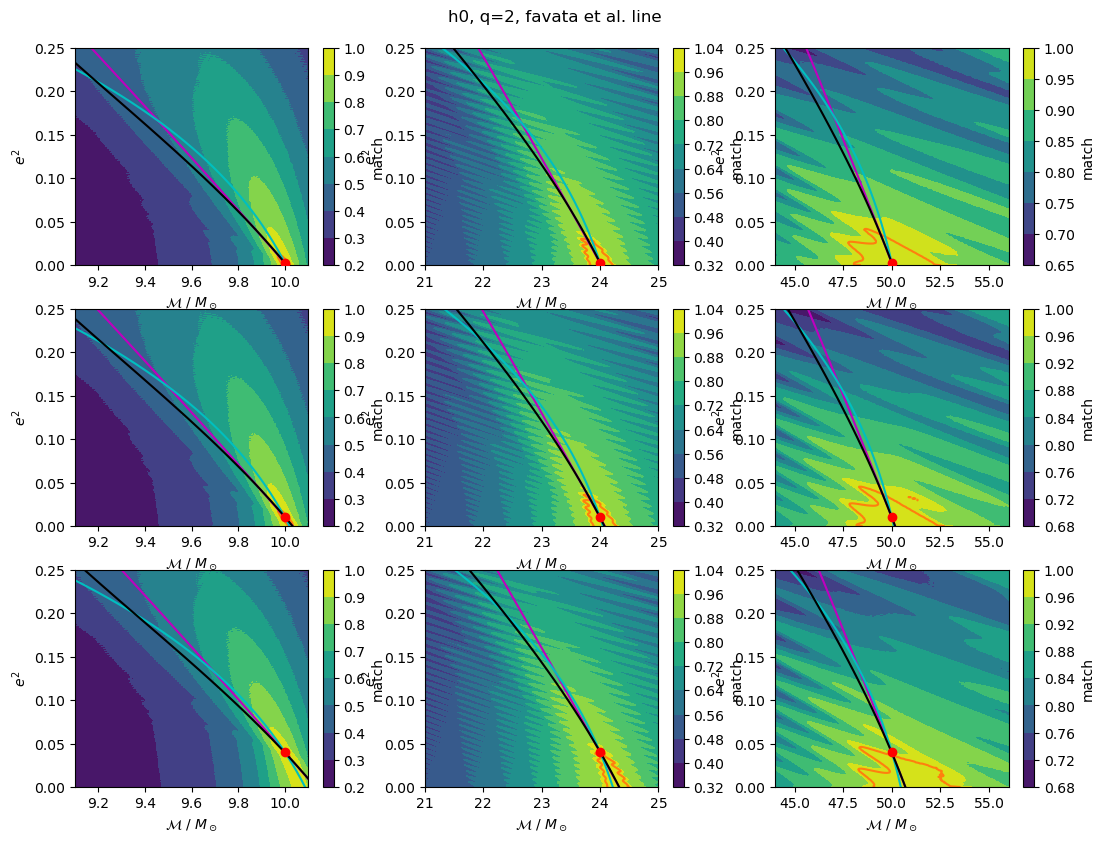

In [5]:
# Load data
with open(os.path.join('e_sqrd_chirp_data_v2', 'dataslot_1', 'all_matches'), 'rb') as fp:
        data = pickle.load(fp)

# Plot each with Favata et al. line
plt.figure(figsize=(6.4*2,4.8*2))
for i, fid_e in enumerate(data.keys()):
    for j, fid_chirp in enumerate(data[fid_e].keys()):
        plt.subplot(len(data.keys()), len(data[fid_e].keys()), i*len(data.keys())+j+1)
        plt.contourf(data[fid_e][fid_chirp]['chirp_vals'], data[fid_e][fid_chirp]['e_vals']**2, data[fid_e][fid_chirp]['h0'])
        plt.colorbar(label='match')
        plt.scatter(fid_chirp, fid_e**2, c='r', zorder=5)
        plt.contour(data[fid_e][fid_chirp]['chirp_vals'], data[fid_e][fid_chirp]['e_vals']**2, data[fid_e][fid_chirp]['h0'], [0.97], colors=['C1'])
        xlims = plt.gca().get_xlim()
        ylims = plt.gca().get_ylim()
        plt.plot(favata_et_al_avg(fid_e, fid_chirp, data[fid_e][fid_chirp]['e_vals']), data[fid_e][fid_chirp]['e_vals']**2, c='m', label='avg')
        plt.plot(favata_et_al_exact(fid_e, fid_chirp, data[fid_e][fid_chirp]['e_vals']), data[fid_e][fid_chirp]['e_vals']**2, c='c', label='exact')
        sparse_e_vals = np.linspace(data[fid_e][fid_chirp]['e_vals'][0], data[fid_e][fid_chirp]['e_vals'][-1], 31)
        init_guess = favata_et_al_avg(fid_e, fid_chirp, 0)
        zero_ecc_chirp_mass = minimize(lambda x: abs(degeneracy_line(x, fid_e) - fid_chirp), init_guess, bounds=[(init_guess*0.75, init_guess*1.25)])['x']
        plt.plot(degeneracy_line(zero_ecc_chirp_mass, sparse_e_vals), sparse_e_vals**2, c='k', label='new')
        plt.ylim(ylims)
        plt.xlim(xlims)
        plt.xlabel('$\mathcal{M}~/~M_\odot$')
        plt.ylabel('$e^2$')
plt.suptitle('h0, q=2, favata et al. line', x=0.5, y=0.92)

Average frequency: 32.516248909453864 Hz
Given_e shifted from 0.05 to 0.014401891692386785
Average frequency: 41.98240505088887 Hz
Given_e shifted from 0.05 to 0.011045142897840234
Average frequency: 32.516248909453864 Hz
Given_e shifted from 0.05 to 0.014401891692386785
Average frequency: 31.81227080237802 Hz
Given_e shifted from 0.05 to 0.014738504129398157
Average frequency: 40.845377636723185 Hz
Given_e shifted from 0.05 to 0.011369789804545286
Average frequency: 31.81227080237802 Hz
Given_e shifted from 0.05 to 0.014738504129398157
Average frequency: 31.640605936873396 Hz
Given_e shifted from 0.05 to 0.014822922402520653
Average frequency: 41.08406755467665 Hz
Given_e shifted from 0.05 to 0.01130010774677259
Average frequency: 31.640605936873396 Hz
Given_e shifted from 0.05 to 0.014822922402520653
Average frequency: 32.551889993739294 Hz
Given_e shifted from 0.1 to 0.028770495046402916
Average frequency: 42.00100567484518 Hz
Given_e shifted from 0.1 to 0.02236986714645971
Average 

Text(0.5, 0.92, 'quad, q=2, favata et al. line')

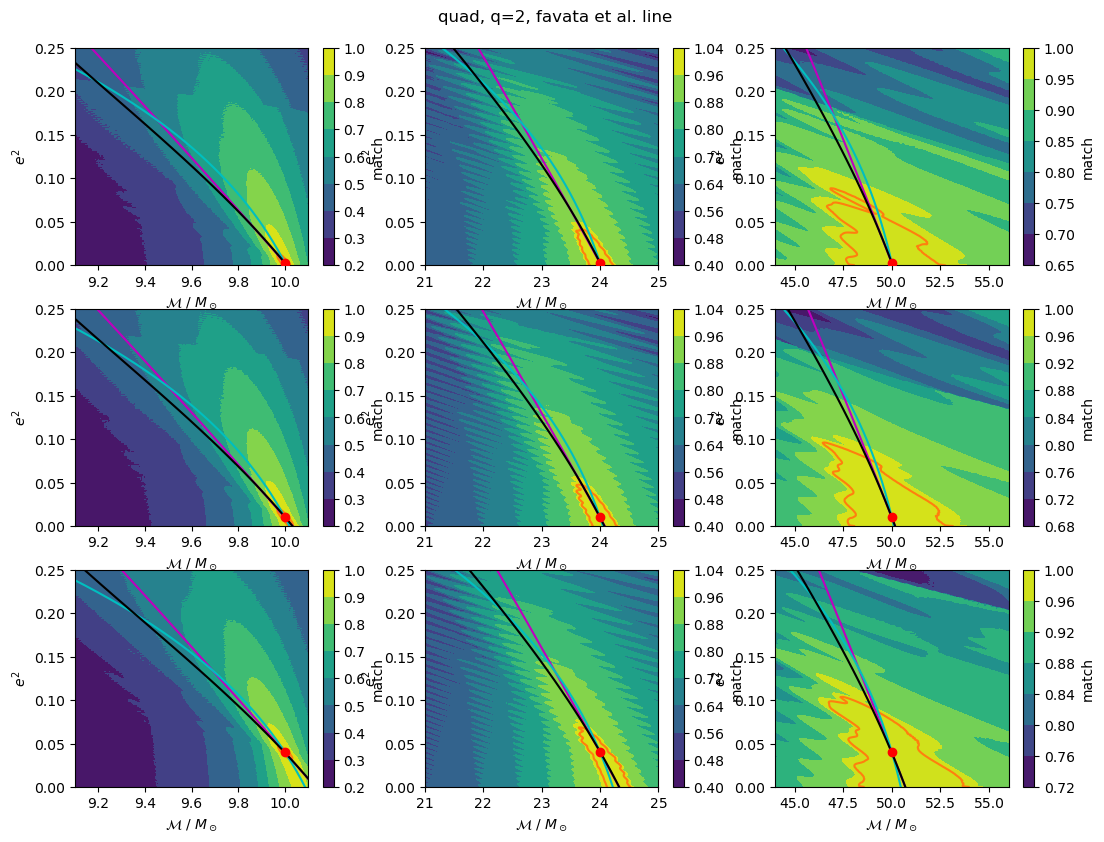

In [6]:
# Load data
with open(os.path.join('e_sqrd_chirp_data_v2', 'dataslot_1', 'all_matches'), 'rb') as fp:
        data = pickle.load(fp)

# Plot each with Favata et al. line
plt.figure(figsize=(6.4*2,4.8*2))
for i, fid_e in enumerate(data.keys()):
    for j, fid_chirp in enumerate(data[fid_e].keys()):
        plt.subplot(len(data.keys()), len(data[fid_e].keys()), i*len(data.keys())+j+1)
        plt.contourf(data[fid_e][fid_chirp]['chirp_vals'], data[fid_e][fid_chirp]['e_vals']**2, data[fid_e][fid_chirp]['quad'])
        plt.colorbar(label='match')
        plt.scatter(fid_chirp, fid_e**2, c='r', zorder=5)
        plt.contour(data[fid_e][fid_chirp]['chirp_vals'], data[fid_e][fid_chirp]['e_vals']**2, data[fid_e][fid_chirp]['quad'], [0.97], colors=['C1'])
        xlims = plt.gca().get_xlim()
        ylims = plt.gca().get_ylim()
        plt.plot(favata_et_al_avg(fid_e, fid_chirp, data[fid_e][fid_chirp]['e_vals']), data[fid_e][fid_chirp]['e_vals']**2, c='m', label='avg')
        plt.plot(favata_et_al_exact(fid_e, fid_chirp, data[fid_e][fid_chirp]['e_vals']), data[fid_e][fid_chirp]['e_vals']**2, c='c', label='exact')
        sparse_e_vals = np.linspace(data[fid_e][fid_chirp]['e_vals'][0], data[fid_e][fid_chirp]['e_vals'][-1], 31)
        init_guess = favata_et_al_avg(fid_e, fid_chirp, 0)
        zero_ecc_chirp_mass = minimize(lambda x: abs(degeneracy_line(x, fid_e) - fid_chirp), init_guess, bounds=[(init_guess*0.75, init_guess*1.25)])['x']
        plt.plot(degeneracy_line(zero_ecc_chirp_mass, sparse_e_vals), sparse_e_vals**2, c='k', label='new')
        plt.ylim(ylims)
        plt.xlim(xlims)
        plt.xlabel('$\mathcal{M}~/~M_\odot$')
        plt.ylabel('$e^2$')
plt.suptitle('quad, q=2, favata et al. line', x=0.5, y=0.92)

Average frequency: 32.516248909453864 Hz
Given_e shifted from 0.05 to 0.014401891692386785
Average frequency: 41.98240505088887 Hz
Given_e shifted from 0.05 to 0.011045142897840234
Average frequency: 32.516248909453864 Hz
Given_e shifted from 0.05 to 0.014401891692386785
Average frequency: 31.81227080237802 Hz
Given_e shifted from 0.05 to 0.014738504129398157
Average frequency: 40.845377636723185 Hz
Given_e shifted from 0.05 to 0.011369789804545286
Average frequency: 31.81227080237802 Hz
Given_e shifted from 0.05 to 0.014738504129398157
Average frequency: 31.640605936873396 Hz
Given_e shifted from 0.05 to 0.014822922402520653
Average frequency: 41.08406755467665 Hz
Given_e shifted from 0.05 to 0.01130010774677259
Average frequency: 31.640605936873396 Hz
Given_e shifted from 0.05 to 0.014822922402520653
Average frequency: 32.551889993739294 Hz
Given_e shifted from 0.1 to 0.028770495046402916
Average frequency: 42.00100567484518 Hz
Given_e shifted from 0.1 to 0.02236986714645971
Average 

Text(0.5, 0.92, 'h1, q=2, favata et al. line')

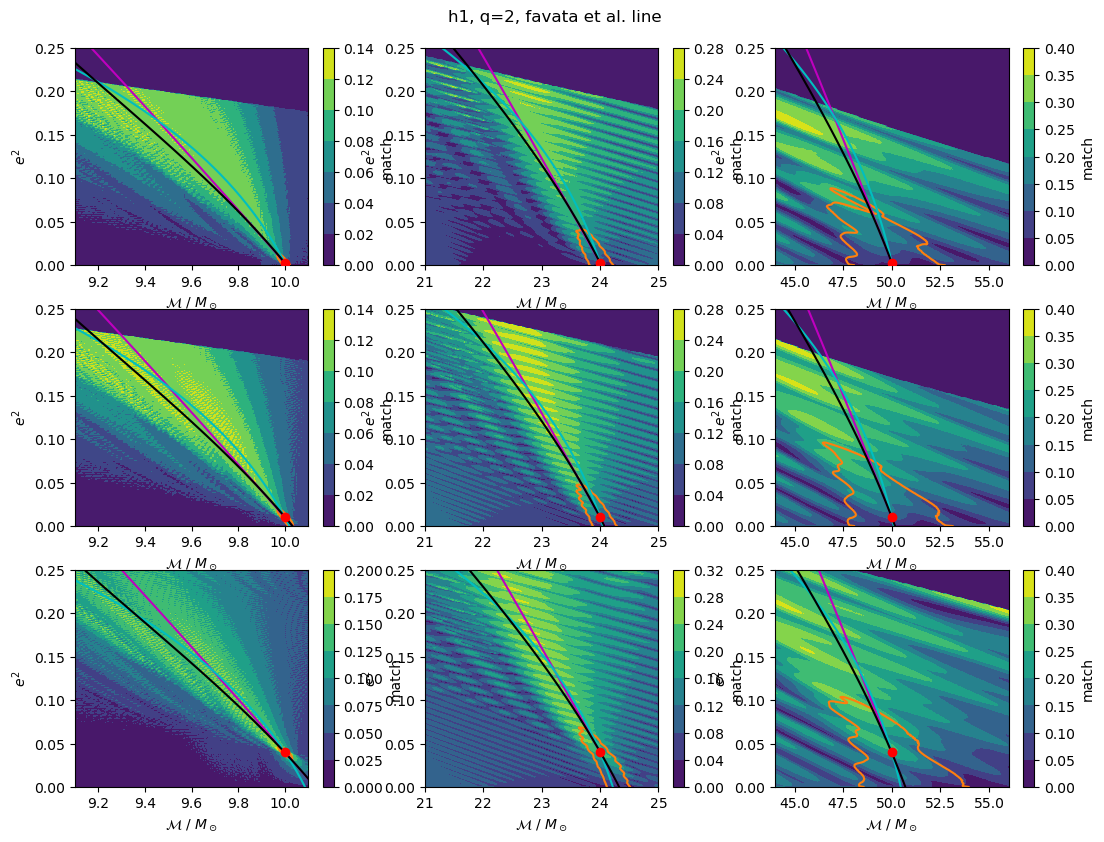

In [7]:
# Load data
with open(os.path.join('e_sqrd_chirp_data_v2', 'dataslot_1', 'all_matches'), 'rb') as fp:
        data = pickle.load(fp)

# Plot each with Favata et al. line
plt.figure(figsize=(6.4*2,4.8*2))
for i, fid_e in enumerate(data.keys()):
    for j, fid_chirp in enumerate(data[fid_e].keys()):
        plt.subplot(len(data.keys()), len(data[fid_e].keys()), i*len(data.keys())+j+1)
        plt.contourf(data[fid_e][fid_chirp]['chirp_vals'], data[fid_e][fid_chirp]['e_vals']**2, data[fid_e][fid_chirp]['h1'])
        plt.colorbar(label='match')
        plt.scatter(fid_chirp, fid_e**2, c='r', zorder=5)
        plt.contour(data[fid_e][fid_chirp]['chirp_vals'], data[fid_e][fid_chirp]['e_vals']**2, data[fid_e][fid_chirp]['quad'], [0.97], colors=['C1'])
        xlims = plt.gca().get_xlim()
        ylims = plt.gca().get_ylim()
        plt.plot(favata_et_al_avg(fid_e, fid_chirp, data[fid_e][fid_chirp]['e_vals']), data[fid_e][fid_chirp]['e_vals']**2, c='m', label='avg')
        plt.plot(favata_et_al_exact(fid_e, fid_chirp, data[fid_e][fid_chirp]['e_vals']), data[fid_e][fid_chirp]['e_vals']**2, c='c', label='exact')
        sparse_e_vals = np.linspace(data[fid_e][fid_chirp]['e_vals'][0], data[fid_e][fid_chirp]['e_vals'][-1], 31)
        init_guess = favata_et_al_avg(fid_e, fid_chirp, 0)
        zero_ecc_chirp_mass = minimize(lambda x: abs(degeneracy_line(x, fid_e) - fid_chirp), init_guess, bounds=[(init_guess*0.75, init_guess*1.25)])['x']
        plt.plot(degeneracy_line(zero_ecc_chirp_mass, sparse_e_vals), sparse_e_vals**2, c='k', label='new')
        plt.ylim(ylims)
        plt.xlim(xlims)
        plt.xlabel('$\mathcal{M}~/~M_\odot$')
        plt.ylabel('$e^2$')
plt.suptitle('h1, q=2, favata et al. line', x=0.5, y=0.92)

Average frequency: 32.516248909453864 Hz
Given_e shifted from 0.05 to 0.014401891692386785
Average frequency: 41.98240505088887 Hz
Given_e shifted from 0.05 to 0.011045142897840234
Average frequency: 32.516248909453864 Hz
Given_e shifted from 0.05 to 0.014401891692386785
Average frequency: 31.81227080237802 Hz
Given_e shifted from 0.05 to 0.014738504129398157
Average frequency: 40.845377636723185 Hz
Given_e shifted from 0.05 to 0.011369789804545286
Average frequency: 31.81227080237802 Hz
Given_e shifted from 0.05 to 0.014738504129398157
Average frequency: 31.640605936873396 Hz
Given_e shifted from 0.05 to 0.014822922402520653
Average frequency: 41.08406755467665 Hz
Given_e shifted from 0.05 to 0.01130010774677259
Average frequency: 31.640605936873396 Hz
Given_e shifted from 0.05 to 0.014822922402520653
Average frequency: 32.551889993739294 Hz
Given_e shifted from 0.1 to 0.028770495046402916
Average frequency: 42.00100567484518 Hz
Given_e shifted from 0.1 to 0.02236986714645971
Average 

Text(0.5, 0.92, 'h1/h0, q=2, favata et al. line')

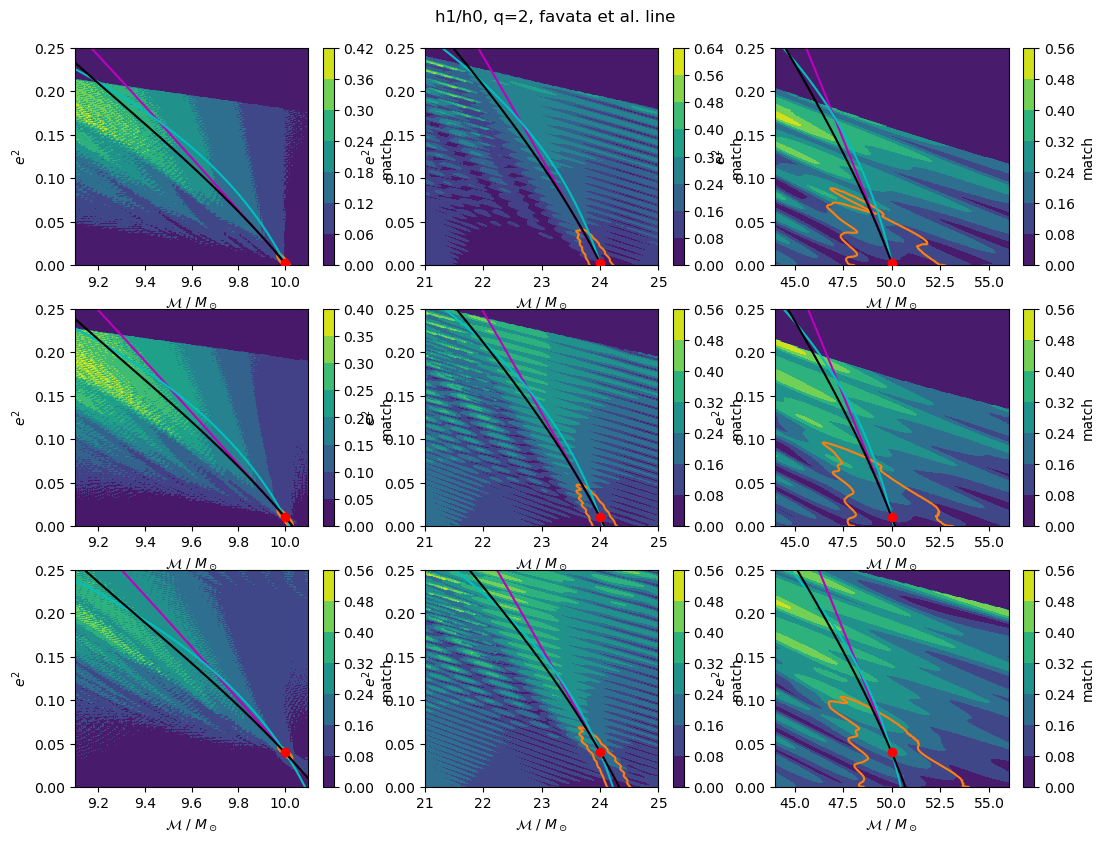

In [8]:
# Load data
with open(os.path.join('e_sqrd_chirp_data_v2', 'dataslot_1', 'all_matches'), 'rb') as fp:
        data = pickle.load(fp)

# Plot each with Favata et al. line
plt.figure(figsize=(6.4*2,4.8*2))
for i, fid_e in enumerate(data.keys()):
    for j, fid_chirp in enumerate(data[fid_e].keys()):
        plt.subplot(len(data.keys()), len(data[fid_e].keys()), i*len(data.keys())+j+1)
        plt.contourf(data[fid_e][fid_chirp]['chirp_vals'], data[fid_e][fid_chirp]['e_vals']**2, data[fid_e][fid_chirp]['h1_h0'])
        plt.colorbar(label='match')
        plt.scatter(fid_chirp, fid_e**2, c='r', zorder=5)
        plt.contour(data[fid_e][fid_chirp]['chirp_vals'], data[fid_e][fid_chirp]['e_vals']**2, data[fid_e][fid_chirp]['quad'], [0.97], colors=['C1'])
        xlims = plt.gca().get_xlim()
        ylims = plt.gca().get_ylim()
        plt.plot(favata_et_al_avg(fid_e, fid_chirp, data[fid_e][fid_chirp]['e_vals']), data[fid_e][fid_chirp]['e_vals']**2, c='m', label='avg')
        plt.plot(favata_et_al_exact(fid_e, fid_chirp, data[fid_e][fid_chirp]['e_vals']), data[fid_e][fid_chirp]['e_vals']**2, c='c', label='exact')
        sparse_e_vals = np.linspace(data[fid_e][fid_chirp]['e_vals'][0], data[fid_e][fid_chirp]['e_vals'][-1], 31)
        init_guess = favata_et_al_avg(fid_e, fid_chirp, 0)
        zero_ecc_chirp_mass = minimize(lambda x: abs(degeneracy_line(x, fid_e) - fid_chirp), init_guess, bounds=[(init_guess*0.75, init_guess*1.25)])['x']
        plt.plot(degeneracy_line(zero_ecc_chirp_mass, sparse_e_vals), sparse_e_vals**2, c='k', label='new')
        plt.ylim(ylims)
        plt.xlim(xlims)
        plt.xlabel('$\mathcal{M}~/~M_\odot$')
        plt.ylabel('$e^2$')
plt.suptitle('h1/h0, q=2, favata et al. line', x=0.5, y=0.92)

Average frequency: 32.516248909453864 Hz
Given_e shifted from 0.05 to 0.014401891692386785
Average frequency: 41.98240505088887 Hz
Given_e shifted from 0.05 to 0.011045142897840234
Average frequency: 32.516248909453864 Hz
Given_e shifted from 0.05 to 0.014401891692386785
Average frequency: 31.81227080237802 Hz
Given_e shifted from 0.05 to 0.014738504129398157
Average frequency: 40.845377636723185 Hz
Given_e shifted from 0.05 to 0.011369789804545286
Average frequency: 31.81227080237802 Hz
Given_e shifted from 0.05 to 0.014738504129398157
Average frequency: 31.640605936873396 Hz
Given_e shifted from 0.05 to 0.014822922402520653
Average frequency: 41.08406755467665 Hz
Given_e shifted from 0.05 to 0.01130010774677259
Average frequency: 31.640605936873396 Hz
Given_e shifted from 0.05 to 0.014822922402520653
Average frequency: 32.551889993739294 Hz
Given_e shifted from 0.1 to 0.028770495046402916
Average frequency: 42.00100567484518 Hz
Given_e shifted from 0.1 to 0.02236986714645971
Average 

Text(0.5, 0.92, 'sqrt(h1^2+h2^2)/h0, q=2, favata et al. line')

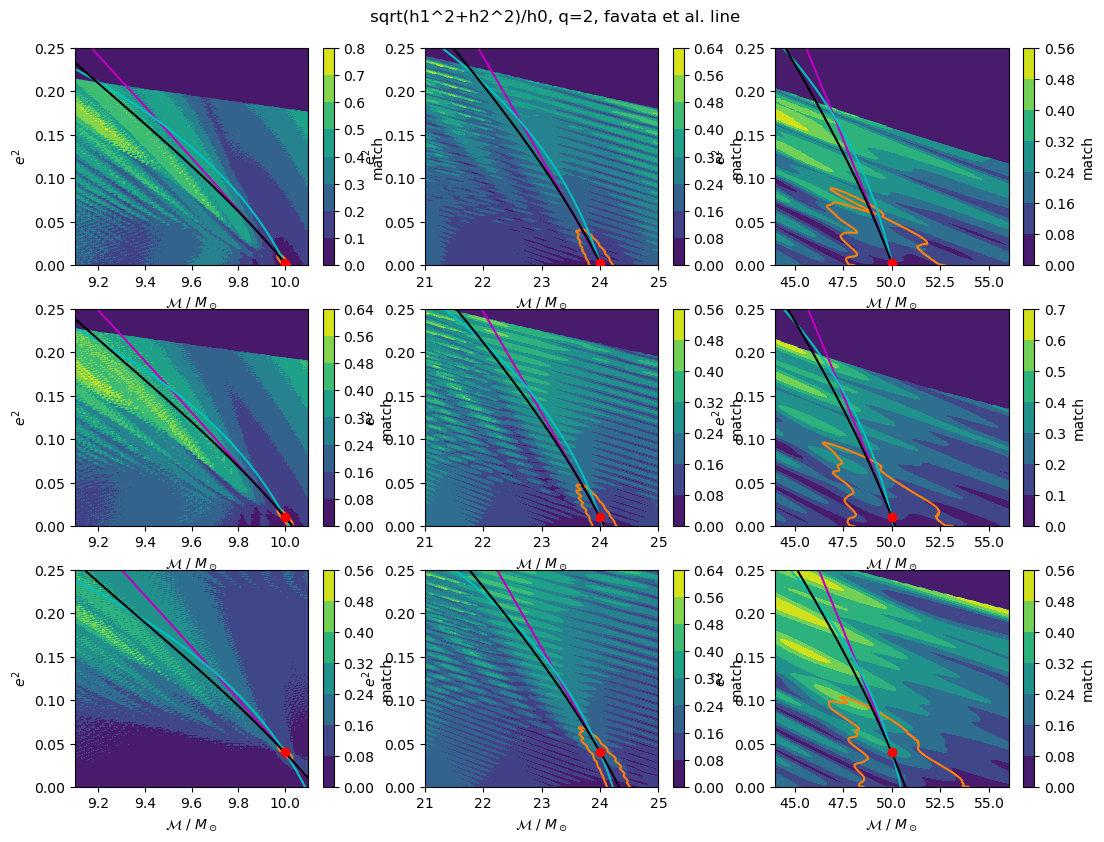

In [9]:
# Load data
with open(os.path.join('e_sqrd_chirp_data_v2', 'dataslot_1', 'all_matches'), 'rb') as fp:
        data = pickle.load(fp)

# Plot each with Favata et al. line
plt.figure(figsize=(6.4*2,4.8*2))
for i, fid_e in enumerate(data.keys()):
    for j, fid_chirp in enumerate(data[fid_e].keys()):
        plt.subplot(len(data.keys()), len(data[fid_e].keys()), i*len(data.keys())+j+1)
        h1_h2_h0 = np.sqrt(data[fid_e][fid_chirp]['h1']**2+data[fid_e][fid_chirp]['h2']**2)/data[fid_e][fid_chirp]['h0']
        plt.contourf(data[fid_e][fid_chirp]['chirp_vals'], data[fid_e][fid_chirp]['e_vals']**2, h1_h2_h0)
        plt.colorbar(label='match')
        plt.scatter(fid_chirp, fid_e**2, c='r', zorder=5)
        plt.contour(data[fid_e][fid_chirp]['chirp_vals'], data[fid_e][fid_chirp]['e_vals']**2, data[fid_e][fid_chirp]['quad'], [0.97], colors=['C1'])
        xlims = plt.gca().get_xlim()
        ylims = plt.gca().get_ylim()
        plt.plot(favata_et_al_avg(fid_e, fid_chirp, data[fid_e][fid_chirp]['e_vals']), data[fid_e][fid_chirp]['e_vals']**2, c='m', label='avg')
        plt.plot(favata_et_al_exact(fid_e, fid_chirp, data[fid_e][fid_chirp]['e_vals']), data[fid_e][fid_chirp]['e_vals']**2, c='c', label='exact')
        sparse_e_vals = np.linspace(data[fid_e][fid_chirp]['e_vals'][0], data[fid_e][fid_chirp]['e_vals'][-1], 31)
        init_guess = favata_et_al_avg(fid_e, fid_chirp, 0)
        zero_ecc_chirp_mass = minimize(lambda x: abs(degeneracy_line(x, fid_e) - fid_chirp), init_guess, bounds=[(init_guess*0.75, init_guess*1.25)])['x']
        plt.plot(degeneracy_line(zero_ecc_chirp_mass, sparse_e_vals), sparse_e_vals**2, c='k', label='new')
        plt.ylim(ylims)
        plt.xlim(xlims)
        plt.xlabel('$\mathcal{M}~/~M_\odot$')
        plt.ylabel('$e^2$')
plt.suptitle('sqrt(h1^2+h2^2)/h0, q=2, favata et al. line', x=0.5, y=0.92)